# Packing CAT Cell demo notebook
The main functions of this demo are located in [chordal_axis_transform.py](../irregular_object_packing/packing/chordal_axis_transform.py)


### Contents
1. Simple CAT Cell demo
2. Larger Demo with cylindrical container and multiple blood cell meshes.

### Pre-requisites
Please install the required packages using the following command:

```bash
pip install -r requirements.txt
```




In [1]:
# IMPORTS
import numpy as np
import pyvista as pv
import trimesh
from tqdm import tqdm

import sys
sys.path.append('../irregular_object_packing/')
from irregular_object_packing.mesh.transform import scale_and_center_mesh, scale_to_volume, translation_matrix
from irregular_object_packing.mesh.utils import print_mesh_info
from irregular_object_packing.packing.chordal_axis_transform import (
    compute_cat_cells,
    face_coord_to_points_and_faces,
)
from irregular_object_packing.packing.initialize import create_packed_scene, init_coordinates, save_image
from irregular_object_packing.packing.plots import create_plot

## Basic CAT Cell demo
The cell below shows a simple demo of computing cat faces. The container is a cube and the object os a cuboid rotated 45 degrees over the z axis. The yellow faces are the CAT faces.

/opt/homebrew/anaconda3/envs/taichi310/lib/python3.10/site-packages/pyvista/core/dataset.py:2668: PyVistaDeprecationWarning: `cell_points` is deprecated. Use `cell[i].points` instead
  warnings.warn(
/opt/homebrew/anaconda3/envs/taichi310/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


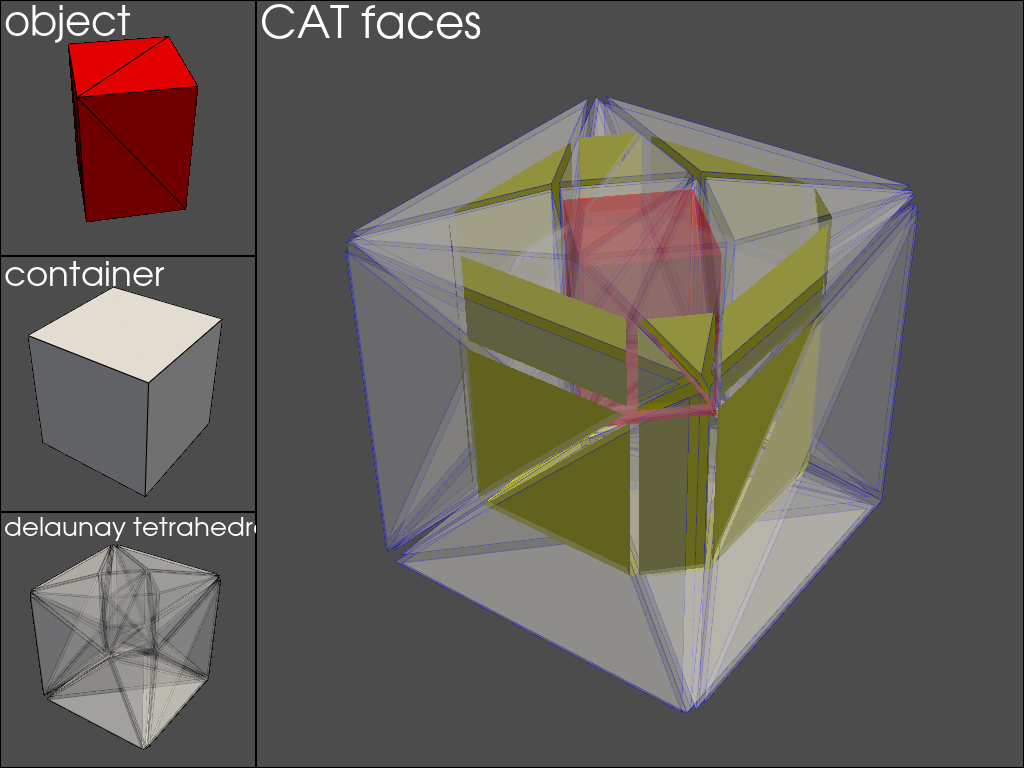

In [2]:
from irregular_object_packing.packing.chordal_axis_transform import main
main()

## Demo computing CAT cells for Blood Cells in a cylindrical container
The cell below shows a demo of computing cat faces for a cylindrical container and multiple blood cell meshes. The yellow faces are the CAT faces and for each red blood cell there is a corresponding CAT cell. 



In [3]:
mesh_volume = 0.1
container_volume = 10
coverage_rate = 0.3

DATA_FOLDER = "../data/mesh/"
loaded_mesh = trimesh.load_mesh(DATA_FOLDER + "RBC_normal.stl")
print_mesh_info(loaded_mesh, "loaded mesh")
# trimesh.Scene([loaded_mesh]).show()

Mesh info loaded mesh: <trimesh.Trimesh(vertices.shape=(642, 3), faces.shape=(1280, 3))>, 
volume: 71.04896973139347, 
bounding box: [[35.089 37.963 35.089]
 [42.911 40.037 42.911]] 
center of mass: [39. 39. 39.]



In [4]:
# Scale the mesh to the desired volume
original_mesh = scale_and_center_mesh(loaded_mesh, mesh_volume)
print_mesh_info(original_mesh, "scaled mesh")

Mesh info scaled mesh: <trimesh.Trimesh(vertices.shape=(642, 3), faces.shape=(1280, 3))>, 
volume: 0.10000000000000006, 
bounding box: [[-0.4383 -0.1162 -0.4383]
 [ 0.4383  0.1162  0.4383]] 
center of mass: [-0. -0. -0.]



In [5]:
container = trimesh.primitives.Sphere(radius=1, center=[0,0,0])
# container = trimesh.primitives.Cylinder(radius=1, height=1)
print_mesh_info(container, "original container")
# container.apply_transform()

container = scale_to_volume(container, container_volume)
print_mesh_info(container, "scaled container")

Mesh info original container: <trimesh.primitives.Sphere>, 
volume: 4.1887902047863905, 
bounding box: [[-1. -1. -1.]
 [ 1.  1.  1.]] 
center of mass: [-0.  0.  0.]

Mesh info scaled container: <trimesh.primitives.Sphere>, 
volume: 9.999999999999996, 
bounding box: [[-1.3365 -1.3365 -1.3365]
 [ 1.3365  1.3365  1.3365]] 
center of mass: [0. 0. 0.]



In [6]:
# Initial placement of the objects
objects_coords = init_coordinates(container, original_mesh, coverage_rate=coverage_rate, c_scale=0.9)

scene = create_packed_scene(container, objects_coords, original_mesh, rotate=True)
scene.show()

Skipped 112 points for total of 30 points


In [7]:
# get vertices of the object meshes and the container as preparation for CAT computation

# we resample to simplify and get a more uniform distribution of points
mesh = trimesh.sample.sample_surface_even(original_mesh, 200)[0]
down_scale = 0.1 # initial downscale 
obj_points = []
tf_matrices = []
for i in range(len(objects_coords)):
    # get the object
    object = mesh.copy()
    # random rotation
    M_rot = trimesh.transformations.random_rotation_matrix()
    M_f = trimesh.transformations.scale_matrix(down_scale**(1/3))
    M_t = trimesh.transformations.translation_matrix(objects_coords[i] - np.array([0, 0, 0]))

    M = M_t @ M_f @ M_rot
    # first scale, then rotate, then translate
    points = trimesh.transform_points(object, M)

    tf_matrices.append(M)
    obj_points.append(points)

container_points = trimesh.sample.sample_surface_even(container, 2000)[0]

In [8]:
# compute the cat cells for each object (takes approx. 1-2 min )
data = compute_cat_cells(obj_points, container_points, objects_coords)

/opt/homebrew/anaconda3/envs/taichi310/lib/python3.10/site-packages/pyvista/core/dataset.py:2668: PyVistaDeprecationWarning: `cell_points` is deprecated. Use `cell[i].points` instead
  warnings.warn(


In [9]:
# This next part of code is for the visualization of the CAT cells.
# it processes the output of compute_cat_cells to create a PyVista mesh for each object
# and it applies the corresponding transformations on the object meshes.

# Volumetric downscale before optimizing the packing
down_scale = 0.1

object_meshes = []
cat_meshes = []

lim = len(data.cat_faces.keys()) 
for k, v in tqdm(data.cat_faces.items()):
    if k >= lim - 1:
        break
    cat_points, poly_faces = face_coord_to_points_and_faces(data, k)
    polydata = pv.PolyData(cat_points, poly_faces)
    cat_meshes.append(polydata)

    object_mesh = original_mesh.copy()
    object_mesh.apply_transform(tf_matrices[k])
    # object_mesh.apply_scale(down_scale ** (1 / 3))
    # object_mesh.vertices = trimesh.transformations.transform_points(
    #     object_mesh.vertices, translation_matrix(np.array([0, 0, 0]), objects_coords[k])
    # )
    # object_mesh.transform(np.eye(4), object_coords[k])
    object_meshes.append(object_mesh)

 97%|█████████▋| 30/31 [00:00<00:00, 94.23it/s]


/opt/homebrew/anaconda3/envs/taichi310/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


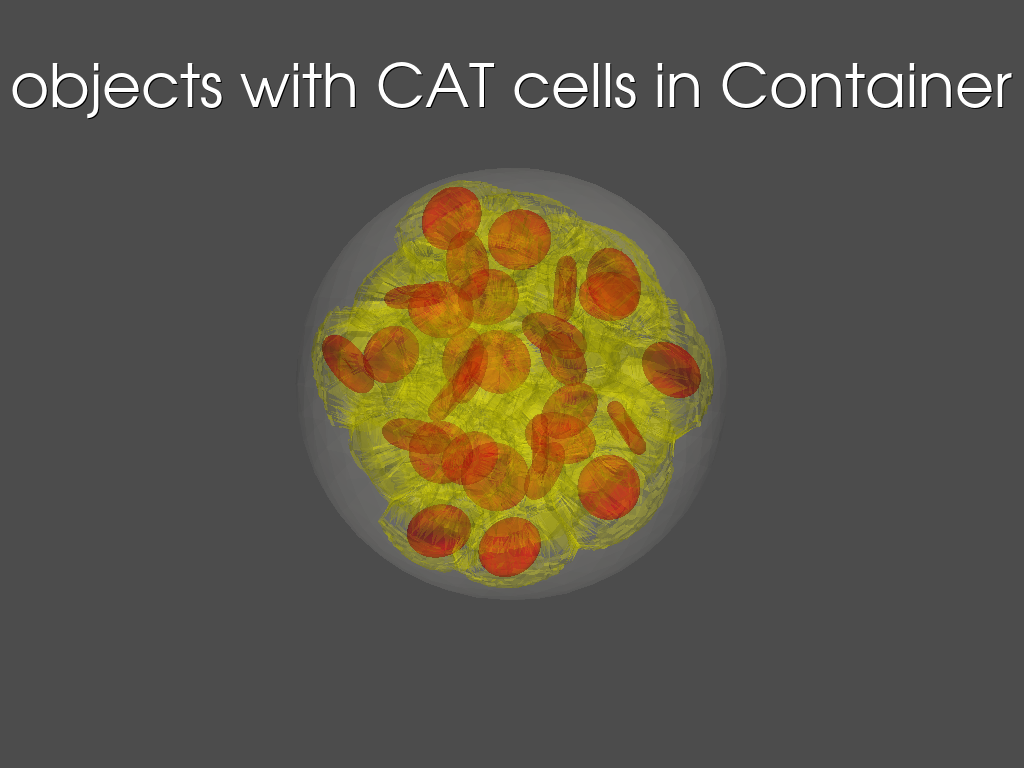

In [10]:
create_plot(objects_coords, object_meshes, cat_meshes, container.to_mesh())